In [8]:
using QuantumOptics
using PyPlot
using LinearAlgebra
using Interpolations
using SplitApplyCombine
using DifferentialEquations
using SimpleDiffEq

#Random number generation
using Statistics
using Distributions
using Random

#Physical constants
using PhysicalConstants.CODATA2018: c_0, k_B, m_u
using Unitful

#Read and write CSV files
using DataFrames
using CSV

#Check time left to execute and benchmark functions
using ProgressMeter
using BenchmarkTools

$\hat{H} = -\Delta(t) \hat{n}_p - \delta(t) \hat{n}_r + \frac{\Omega_r(t)}{2} e^{i \phi_r(t)}\hat{\sigma}_{gp}+ \frac{\Omega_b(t)}{2}e^{i \phi_b(t)}\hat{\sigma}_{pr}+h.c.$

- $\phi_r(t), \phi_b(t)$ - phase noise from red and blue laser


- $\Omega_r(t), \Omega_b(t)$ - atom dynamics and laser amplitude noise


- $\Delta(t), \delta(t)$ - Doppler shifts for red and blue laser


- $\left| g \right>,\left| p \right>,\left| r \right>, \left| gt \right>$ - basis

__Params__

atom_params = [$m, T$]


trap_params = [$U_0, w_0, z_0$]

___

red_laser_params = [$ \Omega_0^{(r)}, w_0^{(r)}, z_0^{(r)}$]

blue_laser_params = [$ \Omega_0^{(b)}, w_0^{(b)}, z_0^{(b)}$]

___
red_laser_phase_params = [$h_0^{(r)}, h_g^{(r)}, \sigma_g ^{(r)}, f_g^{(r)}$]

blue_laser_phase_params = [$h_0^{(b)}, h_g^{(b)}, \sigma_g ^{(b)}, f_g^{(b)}$]
___

detuning_params = [$\Delta_0, \delta_0$]


decay_params = [$\Gamma_g, \Gamma_{gt}$]
___

contrast_params = [$\varepsilon, \varepsilon', \eta$]

___



__Simulation pipeline__

__1.__ Generate N samples of atom initial conditions in trap $(x_i, v_i, z_i, vx_i, vy_i, vz_i)$.

- input: atom_params, trap_params



- output: N samples of initial conditions $[[x_i, y_i, z_i, vx_i, vy_i, vz_i],...]$



__2.__ Generate phase amplitudes of blue and red laser: $S_\phi^{(r)}, S_\phi^{(b)}$

- input: red_laser_phase_params, blue_laser_phase_params



- output: amplitudes_red, amplitudes_blue



__3.__ Run simulation 


- input: t, samples, amplitudes_red, amplitudes_blue, detuning_params


- output: averaged density matrix $\rho(t) = \frac{1}{N}\overset{N}{\underset{i=1}{\sum }}\rho_i(t)$ for states $\left| g \right>, \left| p \right>, \left| r \right>, \left| g' \right>$




__4.__ Calculate expectation values

__Unit scales__

$E = \varepsilon E_0, \;\;\; T = t E_0 , \;\;\; E_0 = k_B \cdot 1\mu K$





$M = m m_u, \;\;\; m_u \simeq 1.66\cdot10^{-27} kg$


$V = v v_0, \;\;\; v_0 = 1 \mu m/ \mu s, \;\;\; vconst = \sqrt{\frac{E0}{m_u}} \simeq 0.09\mu m /\mu s$


$R = r r_0, \;\;\; r_0 = 1\mu m$

In [9]:
c = ustrip(u"m/s", c_0);  #Speed of light
kB = ustrip(u"J/K", k_B)  #Boltzmann constant
mu = ustrip(u"kg", m_u);  #Unit of atomic mass


m = 86.9091835;       #Rb87 mass in a.u.
E0 = kB * 1e-6;       #Characteristic energy in μK
g0 = 9.81 * 1e-6;     #Gravity free fall acceleration
vconst = sqrt(E0/mu); #Useful constant for kinetic energy
r0 = 1e-6;            #Characteristic distance in m

__Laser phase noise generation__

In [10]:
#Laser phase noise spectral density
function Sϕ(f, laser_phase_params)
    h0, hg, σg, fg = laser_phase_params;
    res = 2.0 * h0 * ones(length(f));
    
    if length(hg) > 0
        for i ∈ [1:length(hg);]
            res = res .+ 2*hg[i] .* exp.(-(f .- fg[i]).^2 ./ (2 * σg[i]^2));
        end;
    end;
        
    return res ./ (f .^ 2)
end;



#Laser phase noise amplitudes
function ϕ_amplitudes(f, laser_phase_params)
    h0, hg, σg, fg = laser_phase_params;
    Δf = f[2]-f[1];
    res = 2.0 * h0 * ones(length(f));
    
    if length(hg) > 0
        for i ∈ [1:length(hg);]
            res = res .+ 2*hg[i] .* exp.(-(f .- fg[i]).^2 ./ (2 * σg[i]^2));
        end;
    end;
    
    return 2.0 .* sqrt.(Δf * res) ./ f;
end;



#Phase noise trajectory
function ϕ(tspan, f, amplitudes)
    N = length(f);
    ϕf = rand(Uniform(0.0, 2.0*π), N); #generate random phases for components
    res = vec(sum(amplitudes .* cos.(2*π * f .* tspan' .+ ϕf),dims=1));

    return res
end;

__Beams__

In [11]:
#Beam waist radius
function w(z, w0, z0)
    return w0 .* sqrt.(1.0 .+ (z ./z0) .^2)
end;



#Converter
function w0_to_z0(w0, λ)
    return π*w0^2/λ
end;



#Amplitude of gaussian beam with |E0|=1
function A(x, y, z, w0, z0)
    return (w0 ./ w(z, w0, z0)) .* exp.(- (x .^2 .+ y .^2) ./ (w(z, w0, z0) .^2))
end;



#Phase of gaussian beam
function A_phase(x, y, z, w0, z0)
    k = 2.0 * z0 / w0^2;
    return exp.(-1.0im * k * z .* (0.5*(x .^2 + y .^ 2) ./ (z .^2  + z0 .^2)) + 1.0im * atan.(z ./ z0));
end;



#Complex amplitude of gaussian beam with |E0|=1
function E(x, y, z, w0, z0)
    return A(x,y,z,w0,z0) .* Phase(x,y,z,w0,z0)
end;

__Metropolis-Hastings sampler of initial conditions__

In [12]:
#Potential energy in gaussian beam
function Π(cord, trap_params)
    U0, w0, z0 = trap_params;
    x, y, z, vx, vy, vz = cord;
    return U0 .* (1.0 .- A(x, y, z, w0, z0) .^2);
end;



#Potential energy in gaussian beam in harmonic approximation
function Π_Harmonic(cord, trap_params)
    U0, w0, z0 = trap_params;
    x, y, z, vx, vy, vz = cord;
    
    r2 = x .^2 .+ y .^2;
    return U0 .* (2.0*r2 ./w0^2 + (z ./z0).^2);
end;



#Kinetic energy
function K(cord, trap_params, m)
    U0, w0, z0 = trap_params;
    x, y, z, vx, vy, vz = cord;
    return m/vconst^2 *(vx .^2 + vy .^2 + vz .^2) / 2.0
end;



#Total energy
function H(cord, trap_params, m; harmonic=false)
    if harmonic
        return Π_Harmonic(cord, trap_params) .+ K(cord, trap_params, m)
    else
        return Π(cord, trap_params) .+ K(cord, trap_params, m)
    end;
end;

In [13]:
#Target distribution for Monte-Carlo
function prob_boltzmann(cord, trap_params, atom_params; harmonic=false)    
    m, T = atom_params;
    return exp.(- H(cord, trap_params, m; harmonic) ./ T)
end;



#N - number of samples
#freq - samples[1:freq:end] are taken to reduce correlation between samples
#skip - number of skipped samples at start
function boltzmann_samples(trap_params, atom_params, N; freq=10, skip=1000, harmonic=false)
    U0, w0, z0 = trap_params;
    m, T = atom_params;

    mean = zeros(6);
    vstep = vconst*sqrt(T/m);
    rstep = sqrt(T/U0)/2;
    cov = Diagonal(([w0*rstep, w0*rstep, z0*sqrt(2)*rstep, vstep, vstep, vstep]) .^ 2);
    d = MvNormal(mean, cov);
    
    samples = [[0.0, 0.0, 0.0, vstep/sqrt(3), vstep/sqrt(3), vstep/sqrt(3)]];
    u_acc = rand(Uniform(0.0, 1.0), N*freq + skip);
    acc_rate = 0;
    
    for i ∈ 1:N*freq + skip - 1
        cord_last = samples[end];
        cord_new = cord_last + rand(d);
        p_acc = prob_boltzmann(cord_new, trap_params, atom_params; harmonic)/prob_boltzmann(cord_last, trap_params, atom_params; harmonic);
        
        if p_acc > u_acc[i] && H(cord_new, trap_params, m; harmonic) < U0
            push!(samples, cord_new);
            acc_rate += 1; 
        else
            push!(samples, cord_last);
        end;
    end;
        
    return samples[1+skip:freq:end], acc_rate/(N*freq + skip)
end;

In [14]:
#Function for samples visualisation
function samples_visualise(samples)
    x, y, z, vx, vy, vz = invert(samples);
    figure(figsize=(6,6))
    subplot(221)
    hist2D(x, z, bins=50, range=[[-1.0, 1.0], [-2.5, 2.5]],cmap="plasma", rasterized=true);
    xlabel("x, μm")
    ylabel("z, μm")
    title("Coordinate distribution");

    subplot(222)
    hist(x, bins=[-1.5:0.02:1.5;], density=true, alpha=0.5, label="x")
    hist(z, bins=[-2.0:0.1:2.0;], density=true, alpha=0.5, label="z")
    xlabel("μm")
    ylabel("pdf")
    title("Coordinate distribution");
    legend()

    subplot(223)
    hist2D(vx, vz, bins=50, range=[[-0.3, 0.3], [-0.3, 0.3]],cmap="plasma", rasterized=true);
    xlabel("\$ v_x \$, \$ \\mu m/ \\mu s \$")
    ylabel("\$ v_z \$, \$ \\mu m/ \\mu s \$")
    title("Velocity distribution");


    subplot(224)
    hist(vx, bins=[-0.3:0.01:0.3;], density=true, alpha=0.5, label="\$ v_x \$")
    hist(vz, bins=[-0.3:0.01:0.3;], density=true, alpha=0.5, label="\$ v_z \$")
    xlabel("\$ \\mu m/ \\mu s \$")
    ylabel("pdf")
    title("Velocity distribution");
    legend()

    tight_layout()
end;

_Trap frequencies_

$\omega_r = \sqrt{\frac{4 U_0}{m m_u w_0^2}} = \frac{2}{\sqrt{m}}\frac{1}{w_0} \sqrt{\frac{U_0}{E_0}}\sqrt{\frac{E_0}{m_u}} = 2 \frac{v_{const}}{w_0}  \sqrt{\frac{u_0}{m}}$,

$\omega_z = \sqrt{\frac{2 U_0}{m z_0^2}} = \sqrt{2} \frac{v_{const}}{w_0}  \sqrt{\frac{u_0}{m}}$.

___

_Atom dynamics_

$r(t)=r_i \cos(\omega t) + \frac{v_{i}}{\omega}\sin(\omega t)$,

$v(t)=v_{i}\cos(\omega t) - \omega r_i \sin(\omega t)$.
___

In [15]:
#ωr, ωz trap frequencies
function trap_frequencies(atom_params, trap_params)
    m, T = atom_params;
    U0, w0, z0 = trap_params;
    ω = vconst/w0 * sqrt(U0/m);
    
    return 2*ω, sqrt(2)*ω
end;



#Generate coordinate trajectory from Monte-Carlo initial conditions
function R(t, ri, vi, ω)
    return ri * cos.(ω .* t) + vi/ω * sin.(ω .* t);
end;    



#Generate velocity trajectory from Monte-Carlo initial conditions
function V(t, ri, vi, ω)
    return vi * cos.(ω .* t) - ri * ω * sin.(ω .* t);
end;        

__Detunings and Rabi frequencies__

In [16]:
#Due to atom dynamics
function Ω(x, y, z, laser_params)
    Ω0, w0, z0 = laser_params;
    return Ω0 .* A(x, y, z, w0, z0) .* A_phase(x, y, z, w0, z0);
end;



#Due to Doppler shift for red laser
function Δ(vz, laser_params)
    Ω0, w0, z0 = laser_params
    k = 2 * z0/w0^2;
    return k * vz
end;



#Due to Doppler shifts for red and blue lasers
function δ(vz, red_laser_params, blue_laser_params)
    Ωr0, wr0, zr0 = red_laser_params;
    Ωb0, wb0, zb0 = blue_laser_params;
    
    kr = 2 * zr0/wr0^2;
    kb = 2 * zb0/wb0^2;
    
    return (kr - kb) * vz
end;

__Hamiltonian & Lindbladian__



In [17]:
#Basis states
basis = NLevelBasis(4);
g = nlevelstate(basis, 1);
p = nlevelstate(basis, 2);
r = nlevelstate(basis, 3);
gt = nlevelstate(basis, 4);

#Operators
σgp = g ⊗ dagger(p);
σpg = p ⊗ dagger(g);

σpr = p ⊗ dagger(r);
σrp = r ⊗ dagger(p);

np = p ⊗ dagger(p);
nr = r ⊗ dagger(r);

σgtp = gt ⊗ dagger(p);
σpgt = p ⊗ dagger(gt);

In [18]:
#Two-photon Rydberg hamiltonian for 1 atom
function Hamiltonian(t, Ωr, Ωb, Δ, δ)
    return TimeDependentSum(
        [
        t -> -Δ(t),
        t -> -δ(t),
        t -> Ωr(t) ./2.0,
        t -> conj.(Ωr(t)) ./2.0,
        t -> Ωb(t)/2.0,
        t -> conj.(Ωb(t)) ./2.0,
        ],
        
        [
        np,
        nr,
        σgp,
        σpg,
        σpr,
        σrp  
        ]
    )
end;



#Jump operators for master equation 
function JumpOperators(decay_params)
    Γg, Γgt = decay_params;
    
    return [sqrt(Γg)*σgp, sqrt(Γgt)*σgtp], [sqrt(Γg)*σpg, sqrt(Γgt)*σpgt]
end;

__Simulation__

In [19]:
function simulation(
        tspan, ψ0, 
        
        samples,
        
        f,
        red_laser_phase_amplitudes,
        blue_laser_phase_amplitudes,
        
        red_laser_params,
        blue_laser_params,
        
        detuning_params,
        decay_params;
        
        laser_noise=true,
        atom_dynamics=true
    )
    
    N = length(samples);
    ωr, ωz = trap_frequencies(atom_params, trap_params);
    
    Δ0, δ0 = detuning_params;
    J, Jdagger = JumpOperators(decay_params);
    
    ρ_mean = [zero(ψ0 ⊗ dagger(ψ0)) for _ ∈ 1:length(tspan)];
    
    @showprogress for i ∈ 1:N
        #Atom initial conditions
        xi, yi, zi, vxi, vyi, vzi = samples[i];
        

        #Atom trajectories
        X(t) = R(t, xi, vxi, ωr);
        Y(t) = R(t, yi, vyi, ωr);
        Z(t) = R(t, zi, vzi, ωz);
        Vz(t) = V(t, zi, vzi, ωz);


        #Generate phase noise traces for red and blue lasers
        ϕ_red_res = ϕ(tspan, f, red_laser_phase_amplitudes);
        ϕ_blue_res = ϕ(tspan, f, blue_laser_phase_amplitudes);

        #Interpolate phase noise traces to pass to hamiltonian
        nodes = (tspan, );
        ϕ_red = interpolate(nodes, ϕ_red_res, Gridded(Linear()));
        ϕ_blue = interpolate(nodes, ϕ_blue_res, Gridded(Linear()));
        
        #Hamiltonian params trajectories
        δ_temp(t) = δ(Vz(t), red_laser_params, blue_laser_params) .+ δ0;
        Δ_temp(t) = Δ(Vz(t), red_laser_params);
        Ωr_temp(t) = exp.(1.0im .* ϕ_red(t)) .* Ω(X(t), Y(t), Z(t), red_laser_params);
        Ωb_temp(t) = exp.(1.0im .* ϕ_blue(t)) .* Ω(X(t), Y(t), Z(t), blue_laser_params);
        
        #Hamiltonian
        H_temp(t) = TimeDependentSum(
        [
        t -> -Δ_temp(t),
        t -> -δ_temp(t),
        t -> Ωr_temp(t) ./2.0,
        t -> conj.(Ωr_temp(t)) ./2.0,
        t -> Ωb_temp(t)/2.0,
        t -> conj.(Ωb_temp(t)) ./2.0,
        ],
        
        [
        np,
        nr,
        σgp,
        σpg,
        σpr,
        σrp  
        ]
    );
        
        #Returns hamiltonian and jump operators in a form required by timeevolution.master_dynamic
#         super_operator(t, rho) = [H_temp(t), J, Jdagger];
        super_operator(t, psi) = H_temp(t);

        #Time evolution
#         tout, ρ = timeevolution.master_dynamic(tspan, ρ0, super_operator);
        
        tout, ψ = timeevolution.schroedinger_dynamic(tspan, ψ0, super_operator);
        ρ_mean = ρ_mean .+ ψ .⊗ dagger.(ψ);
    end;

    return ρ_mean/N
end;

__Stable version__

In [20]:
function simulation_stable(
        tspan, ρ0, 
        
        samples,
        
        f,
        red_laser_phase_amplitudes,
        blue_laser_phase_amplitudes,
        
        red_laser_params,
        blue_laser_params,
        
        detuning_params,
        decay_params;
        
        laser_noise=true,
        atom_dynamics=true
    )
    
    N = length(samples);
    ωr, ωz = trap_frequencies(atom_params, trap_params);
    
    Δ0, δ0 = detuning_params;
    J, Jdagger = JumpOperators(decay_params);
    
    ρ_mean = [zero(ρ0) for _ ∈ 1:length(tspan)];
    
    @showprogress for i ∈ 1:N
        #Atom initial conditions
        xi, yi, zi, vxi, vyi, vzi = samples[i];
        

        #Atom trajectories
        X(t) = R(t, xi, vxi, ωr);
        Y(t) = R(t, yi, vyi, ωr);
        Z(t) = R(t, zi, vzi, ωz);
        Vz(t) = V(t, zi, vzi, ωz);


        #Generate phase noise traces for red and blue lasers
        ϕ_red_res = ϕ(tspan, f, red_laser_phase_amplitudes);
        ϕ_blue_res = ϕ(tspan, f, blue_laser_phase_amplitudes);

        #Interpolate phase noise traces to pass to hamiltonian
        nodes = (tspan, );
        ϕ_red = interpolate(nodes, ϕ_red_res, Gridded(Linear()));
        ϕ_blue = interpolate(nodes, ϕ_blue_res, Gridded(Linear()));
        
        #Hamiltonian params trajectories
        δ_temp(t) = δ(Vz(t), red_laser_params, blue_laser_params) .+ δ0;
        Δ_temp(t) = Δ(Vz(t), red_laser_params) .+ Δ0;
        Ωr_temp(t) = exp.(1.0im .* ϕ_red(t)) .* Ω(X(t), Y(t), Z(t), red_laser_params);
        Ωb_temp(t) = exp.(1.0im .* ϕ_blue(t)) .* Ω(X(t), Y(t), Z(t), blue_laser_params);
        
        #Hamiltonian
        H_temp(t) = Hamiltonian(t, Ωr_temp, Ωb_temp, Δ_temp, δ_temp);
        
        #Returns hamiltonian and jump operators in a form required by timeevolution.master_dynamic
        super_operator(t, rho) = [H_temp(t), J, Jdagger];

        #Time evolution
        tout, ρ = timeevolution.master_dynamic(tspan, ρ0, super_operator;);
        
        ρ_mean = ρ_mean .+ ρ;
    end;

    return ρ_mean/N
end;

__Test__

In [21]:
λ = 0.852;
w0 = 1.2;
z0 = w0_to_z0(w0, λ)

5.309734062405284

In [28]:
atom_params = [m, 50.0];
trap_params = [1000.0, w0, z0];

samples, acc_rate = boltzmann_samples(trap_params, atom_params, 100; skip=5000, freq=1000);
acc_rate

0.28678095238095236

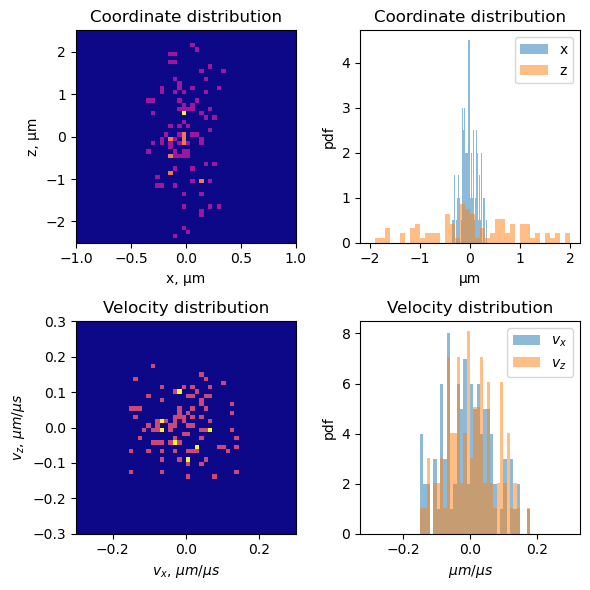

In [29]:
samples_visualise(samples)

In [83]:
#Saffman params
h0 = 13.0 * 1e-6;   #MHz^2/MHz
hg1 = 25.0 * 1e-6;  #MHz^2/MHz
hg2 = 2.0e3 * 1e-6; #MHz^2/MHz
fg1 = 130.0 * 1e-3; #MHz
fg2 = 234.0 * 1e-3; #MHz
σg1 = 18.0 * 1e-3;  #MHz
σg2 = 1.5 * 1e-3;   #MHz

red_laser_params = [2π * 14.0, 5.0, 5.0*3.68];
blue_laser_params = [2π * 14.0, 5.0, 5.0*3.68];

red_laser_phase_params  = [h0, [hg1, hg2], [σg1, σg2], [fg1, fg2]];
blue_laser_phase_params = [h0, [hg1, hg2], [σg1, σg2], [fg1, fg2]];

tspan = [0.0:0.01:15.0;];
f = [0.01:0.01:10.0;];

red_laser_phase_amplitudes = ϕ_amplitudes(f, red_laser_phase_params);
blue_laser_phase_amplitudes = ϕ_amplitudes(f, blue_laser_phase_params);

In [84]:
detuning_params = [2*π * 740.0, 0.0];
Γ = 2.0*π*6;
decay_params = [Γ/4, 3*Γ/4];

ψ0 = g;
ρ0 = ψ0⊗dagger(ψ0);

In [85]:
ρ_mean = simulation_stable(
        tspan, ρ0, 
        
        samples,
        
        f,
        red_laser_phase_amplitudes,
        blue_laser_phase_amplitudes,
        
        red_laser_params,
        blue_laser_params,
        
        detuning_params,
        decay_params
    );

Progress: 100%|█████████████████████████████████████████| Time: 0:07:20


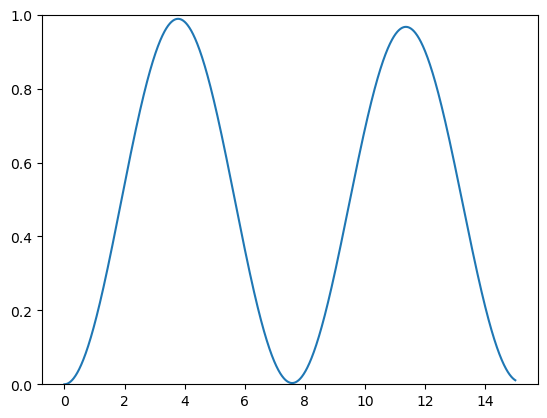

0.9887863463451302

In [87]:
plot(tspan, expect(nr, ρ_mean));
ylim(0.0, 1.0)

maximum(real(expect(nr, ρ_mean)))

__Conclusion__

- It seems like $\Delta$ has very large numerical value (740 MHz), which makes problem stiff. I can switch ODE solver.

https://viralinstruction.com/posts/hardware/

__Ideas for improvement__

0. Julia has its own function profiler https://www.julia-vscode.org/docs/stable/userguide/profiler/ , https://docs.julialang.org/en/v1/stdlib/Profile/



1. Replace [t->Ω(t), t->Ω(t)], [σab, σba] with single operator.



2. Try to include detuning fluctuations into phase noise, less time-dependent terms in hamiltonian.



3. Check time it takes to run interpolation of phase noise and compare it w/o interpolation.



4. Maybe there are some recepies in Bloqade.jl how to speed up code.